# Zillow Home Value Time Series Analysis

Objective and Motivation:

The goal of this project is to predict the top 5 zip codes to invest in using time series analysis.
I will be using Zillow’s extensive range of data on home values throughout the United States.



## Load Data and Import Libraries

In [138]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 8
import seaborn as sns
sns.set()
import plotly.express as px

import statsmodels.api as sm
import itertools

# functions made for this project
import functions as fun

In [201]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
%reload_ext autoreload

In [141]:
z_df = pd.read_csv('csv/zillow_data.csv')
z_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [142]:
z_df.shape

(14723, 272)

# EDA / Preprocessing / Visualizations

The data contains the following values:

- RegionId - regions id (useful for mapping with fips?)
- RegionName - the zip code of the row
- City - city corresponding to the zip code
- State - state the zip code
- Metro - if applicable - the metro area corresponding to the city/zip code
- CountyName - county that the zip code belongs to
- SizeRank - this is based on population density (people per square mile) of the zip code --> 
    - lower scores = higher population density/more urbanized
    - higher scores = lower population density/less urbanized
- dates/home value - monthly home values from April, 1996 - April, 2018

It is important to have a good understanding of the data. 
We will therefore explore the various features.

I started with a function for checking the total and percentages of missing values of each column.¶

In [143]:
missing = fun.missing_data(z_df)
missing

,Total,Percent
Metro,1043,7.084154
1997-03,1039,7.056986
1996-07,1039,7.056986
1997-06,1039,7.056986
1997-02,1039,7.056986
...,...,...
2014-05,56,0.380357
2014-04,56,0.380357
2014-02,56,0.380357
2014-01,56,0.380357


There are random missing values spread through a lot of the months
- until we explore further this is not helpful yet
- until we scale to a specific location this is not helpful yet

In [144]:
# get only zip codes in Chicago
df_chicago = z_df.loc[z_df['City']=='Chicago']
df_chicago.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


Chicago --> I decided to only focus on Chicago zip codes because there are over 14,000 zip codes.
I believe that this is a great area for investment because:

- it is a large city with many zip codes
- it is highly urbanized and has potential for large growth / is constantly growing in population
- walkability scores
- restaurants within walking distance
- possibility of looking into zip codes closest to public transportation
- low carbon emissions because of high population and urbanization

In [145]:
# Let's make a back up to be safe from overriding
df_chicago_copy = df_chicago.copy()
# df_chicago_copy

Let's check the missing values in the new Chicago dataframe.

In [146]:
chi_missing = fun.missing_data(df_chicago)
chi_missing

,Total,Percent
2006-12,1,2.439024
2007-02,1,2.439024
2000-06,1,2.439024
2006-11,1,2.439024
2006-10,1,2.439024
...,...,...
2012-01,1,2.439024
2012-02,1,2.439024
2012-03,1,2.439024
2012-04,1,2.439024


In [147]:
chi_missing.Total.nunique()

1

Looks like possibly only one row has null values.

In [148]:
missing_val = df_chicago.isnull()
null_row = missing_val.any(axis=1)
rows_with_missing = df_chicago[null_row]
rows_with_missing

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
105,84613,60611,Chicago,IL,Chicago,Cook,106,NaN,NaN,NaN,...,1475200,1473900,1469500,1472100,1477800,1486000,1497300,1508600,1508100,1493200


Discovered that the zip code 60611 is our row with missing data.
- It looks like there are months with missing data for this zip code - possibly didn't have early on data?

In [149]:
# Change name of RegionName column to ZipCode to elimate confusion with RegionID column
df_chicago.rename(columns={'RegionName': 'ZipCode'}, inplace=True)
df_chicago.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [150]:
# make sure all zip codes are Cook County 
df_chicago['CountyName'].nunique()

1

In [151]:
df_chicago['ZipCode'].nunique()

41

In [152]:
df_chicago.shape

(41, 272)

I am dropping the column with no data until 2013 - I reference this at the end of this notebook with a graph to show my reasoning!!

In [153]:
plot_df_null = df_chicago.copy()
df_chicago.dropna(inplace=True)
df_chicago['ZipCode'].nunique()

40

## Zip Code Home Value Comparisons

I started my eda with visualizing comparisons of zip codes and their home values for various years.

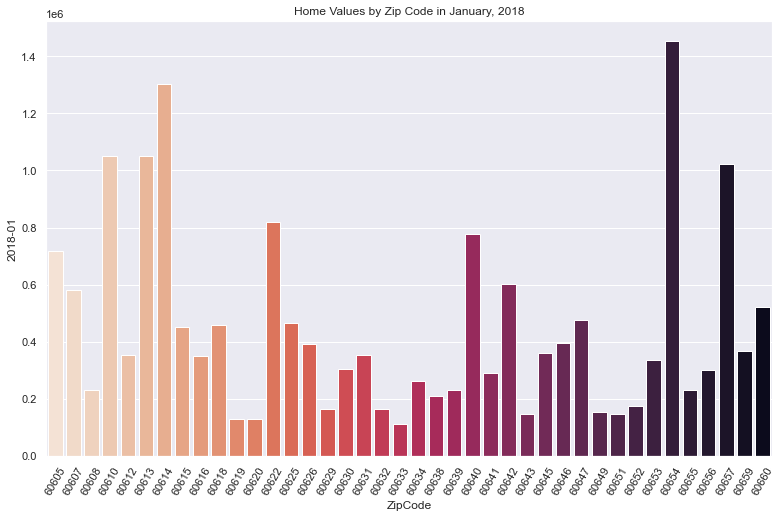

In [154]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='2018-01', data=df_chicago, palette="rocket_r")
plt.title('Home Values by Zip Code in January, 2018')
plt.xticks(rotation=60)
plt.show()

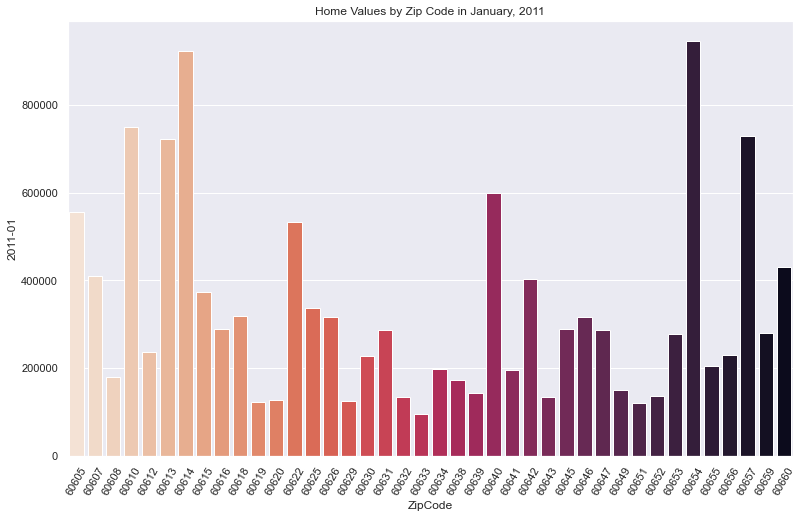

In [155]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='2011-01', data=df_chicago, palette="rocket_r")
plt.title('Home Values by Zip Code in January, 2011')
plt.xticks(rotation=60)
plt.show()

## Size rank filtering and visualizations

Size Rank is Zillow's score for population density.  The lower the score = the higher the population density.
- I decided to use size rank to filter through to lessen the zip code amount.
- I did not have a set amount of zip codes in mind.

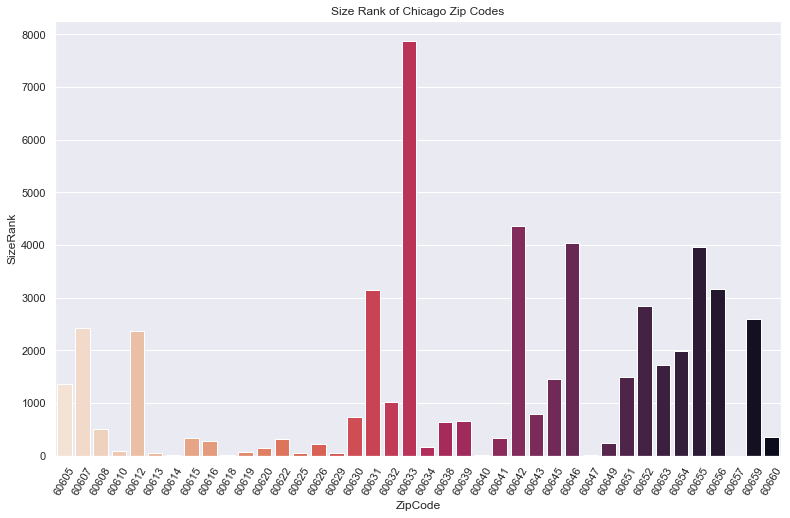

In [156]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='SizeRank', data=df_chicago, palette="rocket_r")
plt.title('Size Rank of Chicago Zip Codes')
plt.xticks(rotation=60)
plt.show()

Here I will pull the 50% size rank quantile value and make a new dataframe with only the zip codes with a size rank under that cut off value.  

In [157]:
# filter zipcodes with a size rank in the bottom 50% 
# (low score = highly urbanized zipcodes)
urban = df_chicago.SizeRank.quantile(q=0.50)
print(f'Size Rank 50% cutoff value: {urban}')
top_zips_df = df_chicago[df_chicago['SizeRank'] < urban]
print(f'Amount of zip codes: {top_zips_df.ZipCode.nunique()}')
top_zips_df.head()


Size Rank 50% cutoff value: 568.5
Amount of zip codes: 20


,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [158]:
# save to csv for later use
top_zips_df.to_csv('top_zips_with_all_columns.csv', index=False)

I wanted to make a dictionary with the regionIDs of all the zip codes in case they are needed for mapping.

In [159]:
# making a dictionary of zip codes with their corresponding region id's 
region_dict = {}
zip_list = top_zips_df.ZipCode.unique()
for i in zip_list:
    region = top_zips_df[top_zips_df['ZipCode']==i].RegionID.values[0]
    region_dict[i] = region

In [160]:
region_dict[60657]

84654

Ok now we have the top 20 Chicago zip codes with the highest population density.  Let's look at the variation of their size rank.

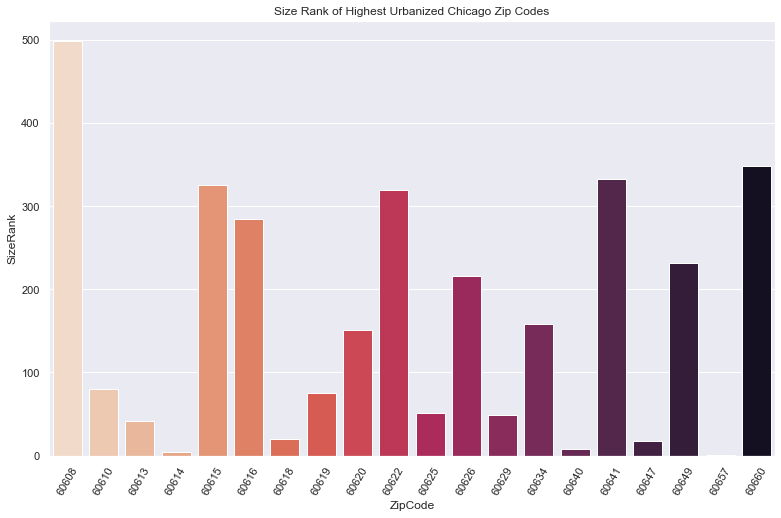

In [161]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='SizeRank', data=top_zips_df, palette="rocket_r")
plt.title('Size Rank of Highest Urbanized Chicago Zip Codes')
plt.xticks(rotation=60)
plt.show()

I thought is was pretty interesting to see how large the size rank range is for these zip codes!  One is still at a 500 score.

Now let's visualize home value comparisons for these zip codes.

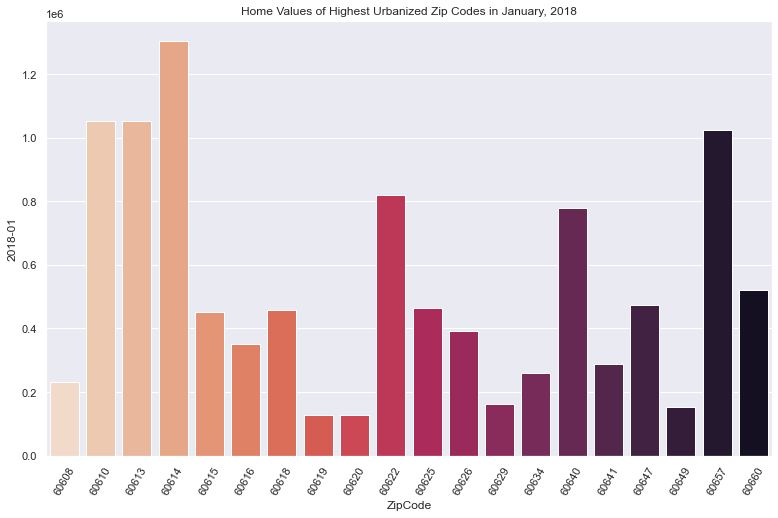

In [162]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='2018-01', data=top_zips_df, palette="rocket_r")
plt.title('Home Values of Highest Urbanized Zip Codes in January, 2018')
plt.xticks(rotation=60)
plt.show()

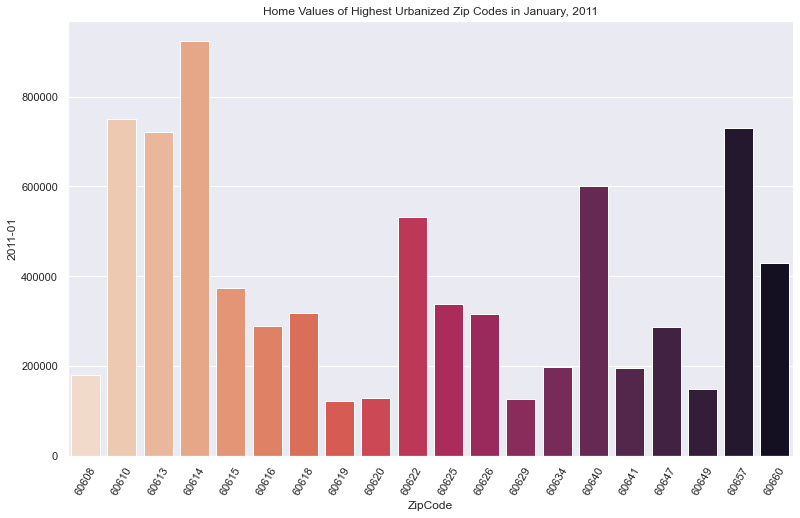

In [163]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='2011-01', data=top_zips_df, palette="rocket_r")
plt.title('Home Values of Highest Urbanized Zip Codes in January, 2011')
plt.xticks(rotation=60)
plt.show()

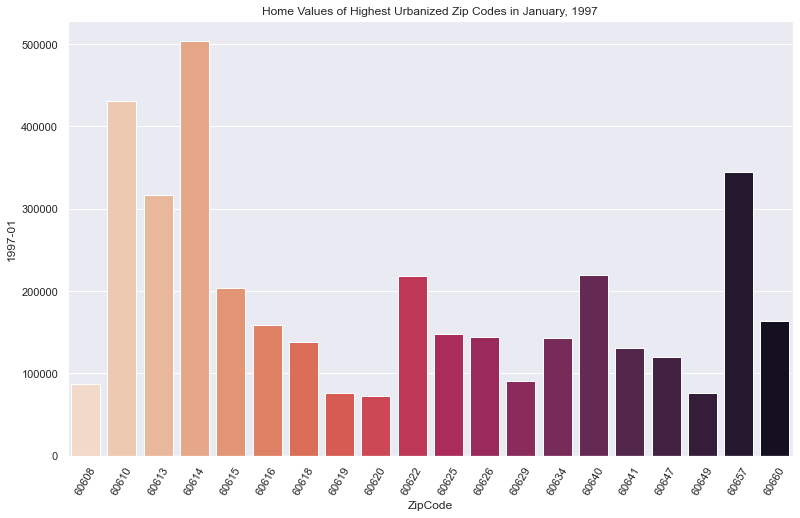

In [164]:
plt.figure(figsize=(13,8))
sns.barplot(x='ZipCode', y='1997-01', data=top_zips_df, palette="rocket_r")
# sns.catplot(x='ZipCode', y='1997-01',  data=top_zips_df, palette= 'rocket_r')
plt.title('Home Values of Highest Urbanized Zip Codes in January, 1997')
plt.xticks(rotation=60)
plt.show()

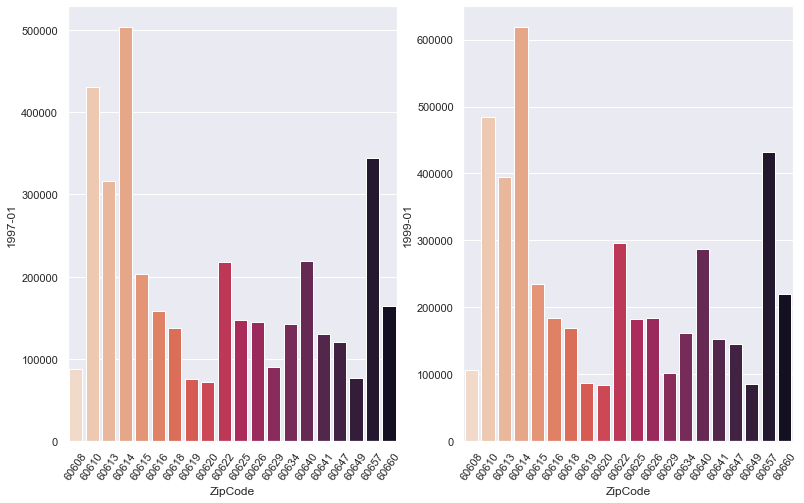

In [165]:
newfig = plt.figure(figsize = (13, 8))
ax = newfig.add_subplot(121)
ax2 = newfig.add_subplot(122)
ax.set_title('')
ax2.set_title('')
sns.barplot(x='ZipCode', y='1997-01', data=top_zips_df, palette="rocket_r",ax=ax,  )
sns.barplot(x='ZipCode', y='1999-01', data=top_zips_df, palette="rocket_r", ax=ax2)
plt.setp(ax.get_xticklabels(), rotation=55)
plt.setp(ax2.get_xticklabels(), rotation=55)
plt.close(2)
plt.close(3)

In [166]:
top_zips_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


It is pretty hard to visual the comparisons of these zip codes with those graphs.  Let's go ahead and try some bar plots.

In [167]:
# splicing columns for bar plot comparison
year_plot = pd.DataFrame()
year_plot['ZipCode'] = top_zips_df['ZipCode']
year_plot['1997-01'] = top_zips_df['1997-01']
year_plot['1999-01'] = top_zips_df['1999-01']
year_plot.set_index('ZipCode', inplace=True)
year_plot.head()

,1997-01,1999-01
ZipCode,,
60657,344400.0,432600.0
60614,503400.0,618600.0
60640,219700.0,287200.0
60647,120300.0,145300.0
60618,138000.0,169000.0


In [168]:
# splicing columns for bar plot comparison
year_plot2 = pd.DataFrame()
year_plot2['ZipCode'] = top_zips_df['ZipCode']
year_plot2['2015-01'] = top_zips_df['2015-01']
year_plot2['2018-01'] = top_zips_df['2018-01']
year_plot2.set_index('ZipCode', inplace=True)
year_plot2.head()

,2015-01,2018-01
ZipCode,,
60657,893000,1024400
60614,1176400,1302700
60640,662200,778500
60647,350400,474500
60618,373100,457400


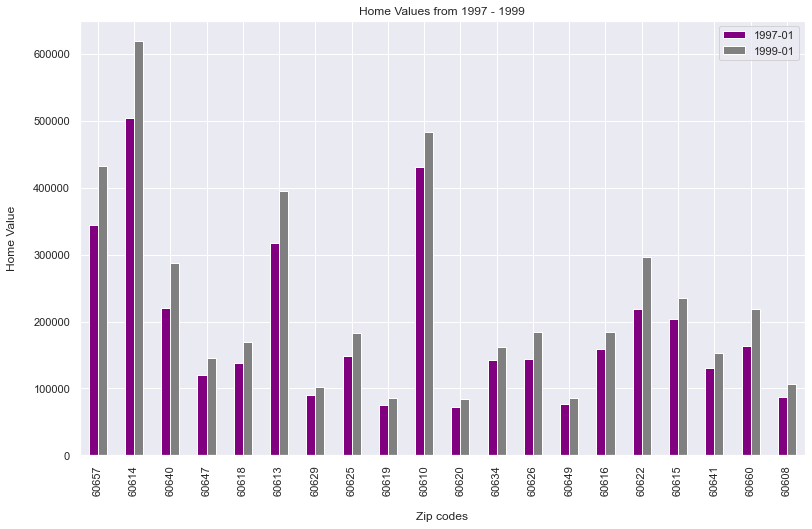

In [169]:
year_plot.plot(kind='bar', figsize=(13, 8), color=['purple', 'gray', 'black'])                                       
plt.xlabel("Zip codes", labelpad=16)
plt.ylabel("Home Value", labelpad=16)
plt.title('Home Values from 1997 - 1999')
plt.show()

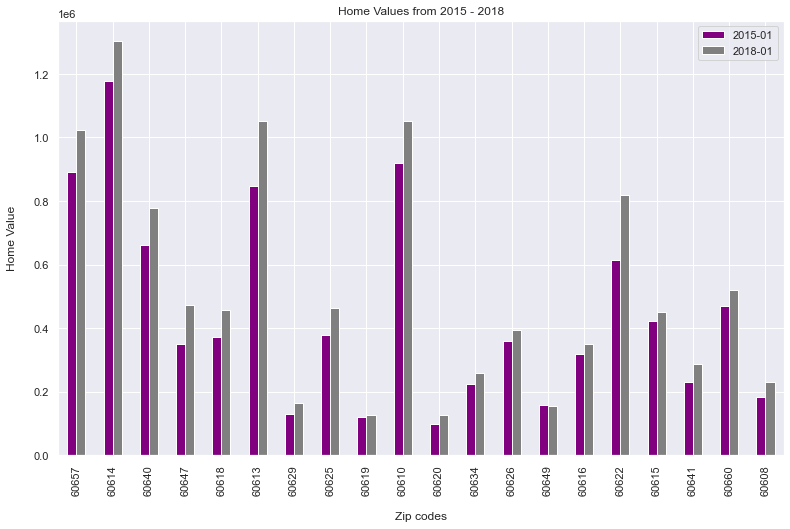

In [170]:
year_plot2.plot(kind='bar', figsize=(13, 8), color=['purple', 'gray', 'black'])                                       
plt.xlabel("Zip codes", labelpad=16)
plt.ylabel("Home Value", labelpad=16)
plt.title('Home Values from 2015 - 2018')
plt.show()

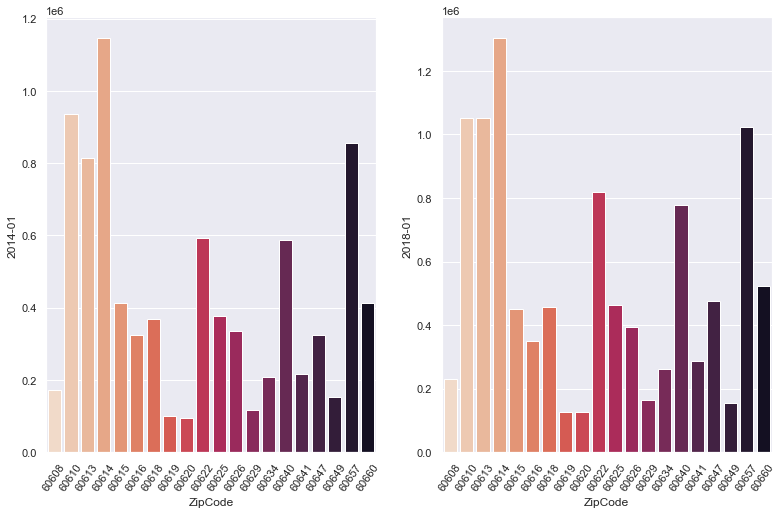

In [171]:
newfig = plt.figure(figsize = (13, 8))
ax = newfig.add_subplot(121)
ax2 = newfig.add_subplot(122)
ax.set_title('')
ax2.set_title('')
sns.barplot(x='ZipCode', y='2014-01', data=top_zips_df, palette="rocket_r",ax=ax,  )
sns.barplot(x='ZipCode', y='2018-01', data=top_zips_df, palette="rocket_r", ax=ax2)
# plt.setp(ax, xticks = [])
plt.setp(ax.get_xticklabels(), rotation=55)
plt.setp(ax2.get_xticklabels(), rotation=55)
# plt.xticks(rotation=50)
plt.close(2)
plt.close(3)

In [172]:
top_zips_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


## Plotting each zip code's value change over time

Now I want to explore the values for our top 20 zip codes over the entire range of dates we have available.

In [173]:
# make a copy to prevent overriding
plotting_df = top_zips_df.copy()
# drop unnecessary columns for plots
plotting_df.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], inplace=True, axis=1)
plotting_df.head()

,ZipCode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,60640,216500.0,216700.0,216900.0,217000.0,217100.0,217200.0,217500.0,217900.0,218600.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,60647,122700.0,122800.0,122800.0,122700.0,122400.0,122000.0,121500.0,120900.0,120500.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,60618,142600.0,143100.0,143400.0,143300.0,142900.0,142200.0,141300.0,140100.0,139000.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [174]:
## Reset the index 
plot_df = plotting_df.reset_index(drop=True)
plot_df.head()

,ZipCode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
2,60640,216500.0,216700.0,216900.0,217000.0,217100.0,217200.0,217500.0,217900.0,218600.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
3,60647,122700.0,122800.0,122800.0,122700.0,122400.0,122000.0,121500.0,120900.0,120500.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
4,60618,142600.0,143100.0,143400.0,143300.0,142900.0,142200.0,141300.0,140100.0,139000.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [175]:
## change zipcodes to string
plot_df["ZipCode"] = plot_df["ZipCode"].astype(str)

In [176]:
## transpose dates to rows
plot_df = plot_df.transpose()
plot_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ZipCode,60657,60614,60640,60647,60618,60613,60629,60625,60619,60610,60620,60634,60626,60649,60616,60622,60615,60641,60660,60608
1996-04,334200,498100,216500,122700,142600,297900,93400,148900,76400,435200,71900,146800,150900,77400,160600,217000,195300,135700,166000,89800
1996-05,335400,500900,216700,122800,143100,300400,94100,149300,77000,435200,72500,147700,150100,77600,160400,216900,196600,136200,165600,89800
1996-06,336500,503100,216900,122800,143400,302600,94600,149600,77400,435100,73000,148300,149300,77600,160100,216900,197800,136400,165200,89800
1996-07,337600,504600,217000,122700,143300,304700,94800,149700,77700,434600,73300,148500,148400,77600,159800,216800,198900,136300,164800,89700


In [177]:
## Renaming columns
header = plot_df.iloc[0] ## grab first row for the column names
plot_df = plot_df[1:] ## take all data after first row
plot_df.columns = header ## reassign all columns to zipcodes
plot_df.head()

ZipCode,60657,60614,60640,60647,60618,60613,60629,60625,60619,60610,60620,60634,60626,60649,60616,60622,60615,60641,60660,60608
1996-04,334200,498100,216500,122700,142600,297900,93400,148900,76400,435200,71900,146800,150900,77400,160600,217000,195300,135700,166000,89800
1996-05,335400,500900,216700,122800,143100,300400,94100,149300,77000,435200,72500,147700,150100,77600,160400,216900,196600,136200,165600,89800
1996-06,336500,503100,216900,122800,143400,302600,94600,149600,77400,435100,73000,148300,149300,77600,160100,216900,197800,136400,165200,89800
1996-07,337600,504600,217000,122700,143300,304700,94800,149700,77700,434600,73300,148500,148400,77600,159800,216800,198900,136300,164800,89700
1996-08,338500,505500,217100,122400,142900,306600,94700,149700,77700,433900,73400,148400,147600,77500,159500,216800,199900,135800,164400,89500


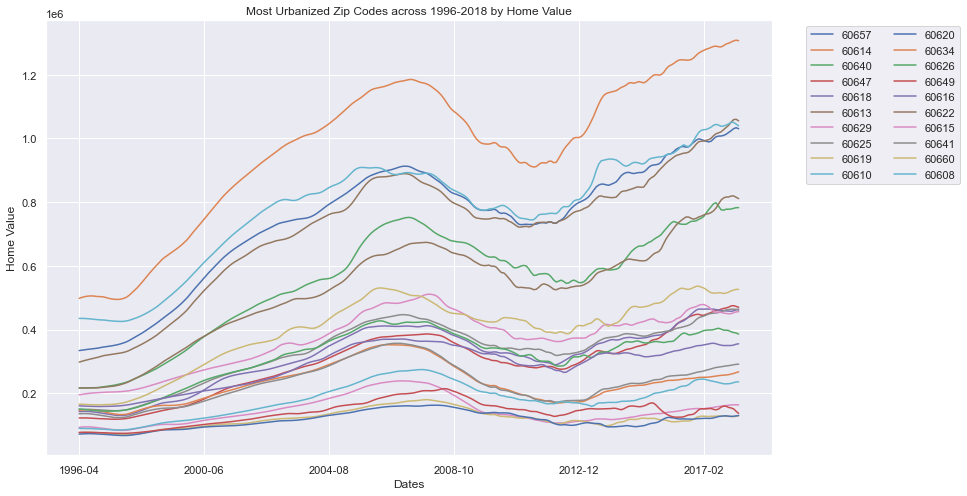

In [178]:
plot_df.plot(figsize=(13, 8))
plt.title('Most Urbanized Zip Codes across 1996-2018 by Home Value')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel('Dates')
plt.ylabel('Home Value')
plt.show()

From the plot above - It is clear that the 2008 economic crash had a large impact on values in Chicago!
- I decided to discard of all dates prior to 2011 where it starts to even out again

In [179]:
# slicing out all dates from January 2011 on
plot_df = plot_df.loc[plot_df.index >= '2011-01']
plot_df.head()

ZipCode,60657,60614,60640,60647,60618,60613,60629,60625,60619,60610,60620,60634,60626,60649,60616,60622,60615,60641,60660,60608
2011-01,729300,923000,600000,286500,317400,722000,125300,337500,122200,749200,127600,196600,316500,148800,289000,532700,372500,195100,429900,179800
2011-02,730200,925000,601600,285800,316300,723400,124300,339500,122200,748600,126900,195000,317900,148700,288100,531700,370600,194600,428800,179400
2011-03,730700,923300,599700,283800,314000,724200,123100,340600,122500,747300,125500,193200,319600,147200,287300,530900,368800,193700,426200,178200
2011-04,730000,916600,590500,282100,311400,722300,121500,340500,123300,745300,124600,190600,321400,144800,286400,530600,368900,191200,419400,176900
2011-05,730100,912400,578900,281700,308200,724100,119800,339500,123500,744200,123400,187600,320300,143200,286200,528700,369900,187600,413200,176800


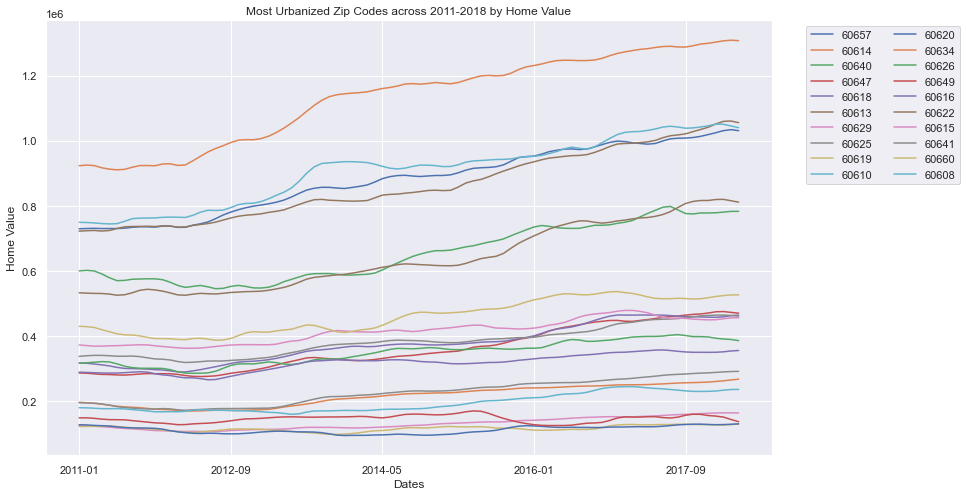

In [180]:
plot_df.plot(figsize=(13, 8))
plt.title('Most Urbanized Zip Codes across 2011-2018 by Home Value')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel('Dates')
plt.ylabel('Home Value')
plt.show()

OK! Looks good - these are the zip codes and years we will model with.

In [181]:
# plot_df.head()

Side note about cell below:  I made a function to use that resets the index of the dataframes above that were used to time plotting so that the dataframe is ready to be saved as a csv for later use.  Otherwise pandas will set a new column "Unnamed: 0" with the current index values.  So, instead of renaming that column or dropping it, etc - it easier to reset the index on this end!

In [182]:
# save our filtered dataframe for future use and to prevent overriding
# NO INDEX with function ran !!
fun.get_index_ready(plot_df)

plot_df.to_csv('plot_df.csv', index=False)

## Reshape from Wide to Long Format

Because this dataframe is in wide format (all the dates are columns), we will need to melt the dataframe to a long format.  

In [183]:
top_zips_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


First I need to splice the dataframe to only dates starting at January 2011 again.

In [184]:
# drop all dates before 2011
for col in top_zips_df.columns:
    if col < '2011-01':
        top_zips_df.drop([col], inplace=True, axis=1)

top_zips_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,2011-01,2011-02,2011-03,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,729300.0,730200.0,730700.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,923000.0,925000.0,923300.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,600000.0,601600.0,599700.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,286500.0,285800.0,283800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,317400.0,316300.0,314000.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


This function is in the functions.py file.  It melts the dataframe and returns the date columns as one time column and it's values as one mean value column.

In [185]:
df = fun.melt_data(top_zips_df)
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,time,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,2011-01-01,729300.0
1,84616,60614,Chicago,IL,Chicago,Cook,4,2011-01-01,923000.0
2,84640,60640,Chicago,IL,Chicago,Cook,8,2011-01-01,600000.0
3,84646,60647,Chicago,IL,Chicago,Cook,17,2011-01-01,286500.0
4,84620,60618,Chicago,IL,Chicago,Cook,20,2011-01-01,317400.0


In [186]:
# drop unnecessary columns
df.drop(['RegionID', 'City', 'State', 'Metro', 
                     'CountyName', 'SizeRank'], inplace=True, axis=1)
# df.head()


In [187]:
df.head()

,ZipCode,time,MeanValue
0,60657,2011-01-01,729300.0
1,60614,2011-01-01,923000.0
2,60640,2011-01-01,600000.0
3,60647,2011-01-01,286500.0
4,60618,2011-01-01,317400.0


In [188]:
# no index
# df.to_csv('chicago_melted.csv', index=False)

In [189]:
# df.set_index('Time', inplace = True)
# df.head()

# ROI Evaluations:

I wanted to explore the return on investment rates of all of the top 20 zip codes.

In [190]:
plotting_df.head()

,ZipCode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,60640,216500.0,216700.0,216900.0,217000.0,217100.0,217200.0,217500.0,217900.0,218600.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,60647,122700.0,122800.0,122800.0,122700.0,122400.0,122000.0,121500.0,120900.0,120500.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,60618,142600.0,143100.0,143400.0,143300.0,142900.0,142200.0,141300.0,140100.0,139000.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [191]:
roi_df = plotting_df.copy()
roi_df.head()

,ZipCode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,60640,216500.0,216700.0,216900.0,217000.0,217100.0,217200.0,217500.0,217900.0,218600.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,60647,122700.0,122800.0,122800.0,122700.0,122400.0,122000.0,121500.0,120900.0,120500.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,60618,142600.0,143100.0,143400.0,143300.0,142900.0,142200.0,141300.0,140100.0,139000.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


First I need to take the average of the month dates for every year so as not to lose any valuable information.  I will make new columns for each year's average values.

In [192]:
year_list = ['1996', '1997','1998', '1999','2000', '2001','2002',
             '2003','2004','2005','2006','2007','2008','2009',
             '2010','2011', '2012', '2013', '2014', '2015', 
             '2016', '2017', '2018']

In [193]:
%reload_ext autoreload

In [194]:
for year in year_list:
    fun.get_mean_year(roi_df, year)

In [195]:
roi_df.head()

,ZipCode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,790743,760244,732548,761040,834854,881141,918897,975076,1001805,1028402
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1014667,964985,920240,965996,1078377,1163246,1196334,1246987,1286311,1304973
7,60640,216500.0,216700.0,216900.0,217000.0,217100.0,217200.0,217500.0,217900.0,218600.0,...,654189,612099,582324,552544,576204,620609,687837,736271,776390,780645
16,60647,122700.0,122800.0,122800.0,122700.0,122400.0,122000.0,121500.0,120900.0,120500.0,...,326094,295397,283307,282759,321985,335174,369550,429273,457312,472169
19,60618,142600.0,143100.0,143400.0,143300.0,142900.0,142200.0,141300.0,140100.0,139000.0,...,349025,325650,305273,304986,346769,371575,381782,433078,461936,460633


Now I can drop all of of the month columns since I have the average for the year.

In [196]:
for col in roi_df:
    if '-' in col:
        roi_df.drop([col], inplace=True, axis=1)
roi_df.head()

,ZipCode,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,60657,345921,352942,396505,466646,565227,653381,711351,744140,783799,...,790743,760244,732548,761040,834854,881141,918897,975076,1001805,1028402
3,60614,512123,499496,561259,651321,750713,853123,931631,993753,1039340,...,1014667,964985,920240,965996,1078377,1163246,1196334,1246987,1286311,1304973
7,60640,223373,227483,260710,313352,379441,439705,488811,525081,559548,...,654189,612099,582324,552544,576204,620609,687837,736271,776390,780645
16,60647,125795,119906,133649,153535,184238,222121,246892,275076,305892,...,326094,295397,283307,282759,321985,335174,369550,429273,457312,472169
19,60618,145467,133178,150818,175660,213341,256170,274249,298255,340297,...,349025,325650,305273,304986,346769,371575,381782,433078,461936,460633


In [197]:
# flipping it for our plot function
plot_roi = roi_df.transpose()

new_header = plot_roi.iloc[0] 
plot_roi = plot_roi[1:] 
plot_roi.columns = new_header 

Below is full range of dates - I just wanted to confirm that the 2008 economic crash looked the same with the averages for the years and it does.

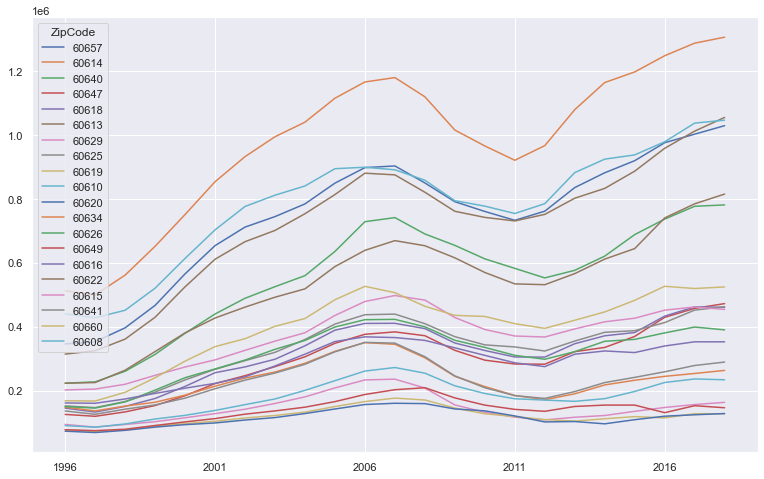

In [198]:
# average value for each year 
fun.plot(plot_roi)

Again eliminating all years before 2011 to account for 2008 crash.

In [199]:
roi_clean = roi_df.copy()
# dropping all dates before 2011
for col in roi_df.columns:
    if col < '2011':
        roi_df.drop([col], inplace=True, axis=1)

roi_df.head()

,ZipCode,2011,2012,2013,2014,2015,2016,2017,2018
0,60657,732548,761040,834854,881141,918897,975076,1001805,1028402
3,60614,920240,965996,1078377,1163246,1196334,1246987,1286311,1304973
7,60640,582324,552544,576204,620609,687837,736271,776390,780645
16,60647,283307,282759,321985,335174,369550,429273,457312,472169
19,60618,305273,304986,346769,371575,381782,433078,461936,460633


Using a function I made to get the ROI - I am getting yearly ROI for each column and making new columns for the ROI values.

In [203]:
roi_df['2012-01'] = fun.get_return_rate('2011', '2012', roi_df)
roi_df['2013-01'] = fun.get_return_rate('2012', '2013', roi_df)
roi_df['2014-01'] = fun.get_return_rate('2013', '2014', roi_df) 
roi_df['2015-01'] = fun.get_return_rate('2014', '2015', roi_df)
roi_df['2016-01'] = fun.get_return_rate('2015', '2016', roi_df) 
roi_df['2017-01'] = fun.get_return_rate('2016', '2017', roi_df) 
roi_df['2018-01'] = fun.get_return_rate('2017', '2018', roi_df) 
roi_df.drop(['2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018'], inplace=True, axis=1)
roi_df.head()

,ZipCode,2012-01,2013-01,2014-01,2015-01,2016-01,2017-01,2018-01
0,60657,3.889438,9.699096,5.544323,4.284899,6.113743,2.741222,2.654908
3,60614,4.972181,11.633692,7.870068,2.844454,4.234018,3.153521,1.450816
7,60640,-5.113992,4.282012,7.706472,10.832585,7.041494,5.448945,0.548049
16,60647,-0.193430,13.872591,4.096154,10.256165,16.161007,6.531741,3.248767
19,60618,-0.094014,13.699973,7.153465,2.746956,13.435940,6.663465,-0.282074


In [204]:
mean_roi = roi_df.copy()

In [205]:
roi_df.columns

Index(['ZipCode', '2012-01', '2013-01', '2014-01', '2015-01', '2016-01',
       '2017-01', '2018-01'],
      dtype='object')

In [206]:
roi_df.ZipCode.nunique()

20

I will group the dataframe by each unique zip code.

In [207]:
date_roi = roi_df.groupby('ZipCode').mean()
date_roi.head()

,2012-01,2013-01,2014-01,2015-01,2016-01,2017-01,2018-01
ZipCode,,,,,,,
60608,-2.341290,-2.285463,4.987373,12.844613,14.211499,4.908628,-1.051413
60610,4.072758,12.379611,4.776315,1.433900,4.370771,5.969273,0.894869
60613,2.800758,6.726716,3.833597,6.477232,8.053622,5.611739,4.230416
60614,4.972181,11.633692,7.870068,2.844454,4.234018,3.153521,1.450816
60615,-0.811388,6.834005,5.682550,2.695844,5.904310,2.210173,-1.655522


Now we can start to visualize the return on investments for these years.

In [208]:
# transpose for plotting
zip_roi = date_roi.transpose()
zip_roi

ZipCode,60608,60610,60613,60614,60615,60616,60618,60619,60620,60622,60625,60626,60629,60634,60640,60641,60647,60649,60657,60660
2012-01,-2.341290,4.072758,2.800758,4.972181,-0.811388,-4.160558,-0.094014,-8.022377,-15.460059,-0.464957,-3.789420,-3.967896,-7.329343,-7.259572,-5.113992,-4.601941,-0.193430,-4.296845,3.889438,-3.564407
2013-01,-2.285463,12.379611,6.726716,11.633692,6.834005,14.101278,13.699973,-4.457251,1.221693,6.504420,9.614868,7.976269,7.589754,10.836620,4.282012,12.117835,13.872591,11.178277,9.699096,6.410396
2014-01,4.987373,4.776315,3.833597,7.870068,5.682550,3.233028,7.153465,7.098000,-6.949125,8.019389,7.712691,10.070041,4.690640,14.589182,7.706472,14.268834,4.096154,2.855986,5.544323,6.198918
2015-01,12.844613,1.433900,6.477232,2.844454,2.695844,-1.537816,2.746956,6.021584,13.437792,5.379275,1.326780,1.691988,10.669008,6.722084,10.832585,7.232349,10.256165,-0.022590,4.284899,8.113196
2016-01,14.211499,4.370771,8.053622,4.234018,5.904310,6.449733,13.435940,-3.305035,9.975302,14.866787,6.512204,5.618084,8.872093,5.235217,7.041494,7.210999,16.161007,-15.246162,6.113743,9.106551
2017-01,4.908628,5.969273,5.611739,3.153521,2.210173,3.825325,6.663465,11.312784,3.714702,5.969302,9.456422,4.794571,6.221653,3.671752,5.448945,7.593036,6.531741,16.622233,2.741222,-1.326354
2018-01,-1.051413,0.894869,4.230416,1.450816,-1.655522,-0.016158,-0.282074,-0.193671,3.078811,3.888344,2.328829,-2.203491,4.313305,3.772990,0.548049,3.871421,3.248767,-4.243521,2.654908,0.957737


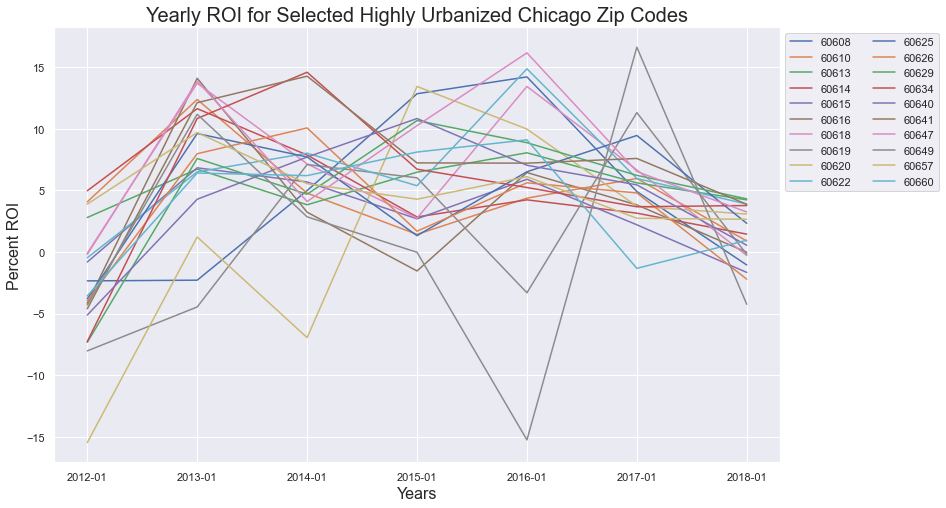

In [209]:
zip_roi.plot(figsize=(13, 8))
plt.xlabel('Years', fontsize=16)
plt.ylabel('Percent ROI',  fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=2)
plt.title('Yearly ROI for Selected Highly Urbanized Chicago Zip Codes',  fontsize=20)
plt.show()

In [210]:
date_roi['2018-01'].unique()

array([-1.05141273,  0.89486883,  4.23041592,  1.45081555, -1.65552227,
       -0.01615834, -0.28207371, -0.19367132,  3.07881082,  3.88834402,
        2.32882897, -2.20349139,  4.31330499,  3.77299018,  0.54804931,
        3.87142145,  3.24876671, -4.24352074,  2.65490789,  0.95773748])

Using the same method I used to filter the zip codes by size rank, I will filter out the zip codes with an ROI percentage over 3% in 2018.
- I will take the 75% quantile of the 2018 column and filter all zip codes with an ROI over that cut off value.
- Return in a seperate dataframe.

In [211]:
# filter zipcodes ROI over 3% in 2018

top_percent = date_roi['2018-01'].quantile(q=0.75)
print(f'2018 ROI 75% cutoff value: {top_percent}')
top_roi = date_roi[date_roi['2018-01'] > top_percent]
print(f'Amount of zip codes: {top_roi.index.nunique()}')
top_roi.head()


2018 ROI 75% cutoff value: 3.3798225750889515
Amount of zip codes: 5


,2012-01,2013-01,2014-01,2015-01,2016-01,2017-01,2018-01
ZipCode,,,,,,,
60613,2.800758,6.726716,3.833597,6.477232,8.053622,5.611739,4.230416
60622,-0.464957,6.504420,8.019389,5.379275,14.866787,5.969302,3.888344
60629,-7.329343,7.589754,4.690640,10.669008,8.872093,6.221653,4.313305
60634,-7.259572,10.836620,14.589182,6.722084,5.235217,3.671752,3.772990
60641,-4.601941,12.117835,14.268834,7.232349,7.210999,7.593036,3.871421


In [212]:
top_roi.index

Int64Index([60613, 60622, 60629, 60634, 60641], dtype='int64', name='ZipCode')

In [213]:
# transpose to plot again
top_roi_plot = top_roi.transpose()
top_roi_plot

ZipCode,60613,60622,60629,60634,60641
2012-01,2.800758,-0.464957,-7.329343,-7.259572,-4.601941
2013-01,6.726716,6.504420,7.589754,10.836620,12.117835
2014-01,3.833597,8.019389,4.690640,14.589182,14.268834
2015-01,6.477232,5.379275,10.669008,6.722084,7.232349
2016-01,8.053622,14.866787,8.872093,5.235217,7.210999
2017-01,5.611739,5.969302,6.221653,3.671752,7.593036
2018-01,4.230416,3.888344,4.313305,3.772990,3.871421


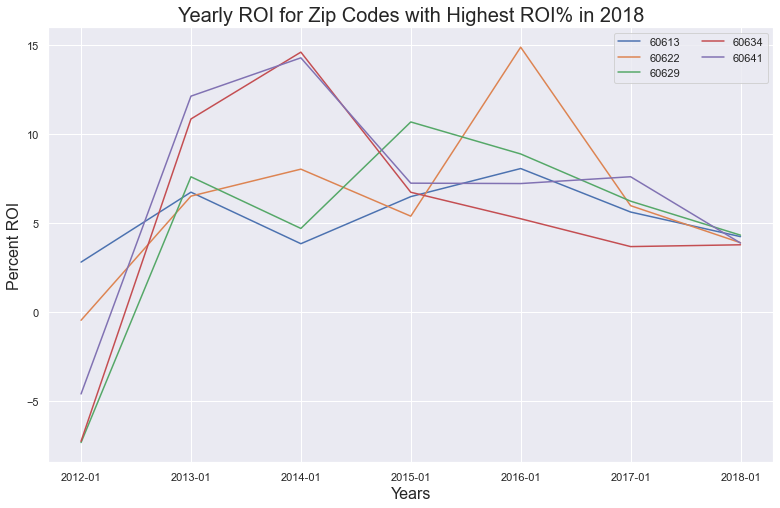

In [214]:
top_roi_plot.plot(figsize=(13, 8))
plt.xlabel('Years', fontsize=16)
plt.ylabel('Percent ROI',  fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), loc="best", ncol=2)
plt.title('Yearly ROI for Zip Codes with Highest ROI% in 2018',  fontsize=20)
plt.show()

In [215]:
date_roi.head()

,2012-01,2013-01,2014-01,2015-01,2016-01,2017-01,2018-01
ZipCode,,,,,,,
60608,-2.341290,-2.285463,4.987373,12.844613,14.211499,4.908628,-1.051413
60610,4.072758,12.379611,4.776315,1.433900,4.370771,5.969273,0.894869
60613,2.800758,6.726716,3.833597,6.477232,8.053622,5.611739,4.230416
60614,4.972181,11.633692,7.870068,2.844454,4.234018,3.153521,1.450816
60615,-0.811388,6.834005,5.682550,2.695844,5.904310,2.210173,-1.655522


In [216]:
import cufflinks as cf
cf.go_offline()
top_roi_plot.iplot(title="ROI of Chicago Homes 2011-2018",
                    xTitle="Year",
                    yTitle="Percent ROI",
                   shape=(13,8),
                    subplot_titles=True,
                    fill=True,)

In [217]:
# roi_clean.head()
for col in roi_clean.columns:
    if col < '2011':
        roi_clean.drop([col], inplace=True, axis=1)

roi_clean.head()

,ZipCode,2011,2012,2013,2014,2015,2016,2017,2018
0,60657,732548,761040,834854,881141,918897,975076,1001805,1028402
3,60614,920240,965996,1078377,1163246,1196334,1246987,1286311,1304973
7,60640,582324,552544,576204,620609,687837,736271,776390,780645
16,60647,283307,282759,321985,335174,369550,429273,457312,472169
19,60618,305273,304986,346769,371575,381782,433078,461936,460633


In [218]:
# roi_clean = roi_clean.set_index('ZipCode')

roi_clean = roi_clean.transpose()
roi_clean.head()

,0,3,7,16,19,40,48,50,74,79,150,157,215,231,284,318,324,332,347,497
ZipCode,60657,60614,60640,60647,60618,60613,60629,60625,60619,60610,60620,60634,60626,60649,60616,60622,60615,60641,60660,60608
2011,732548,920240,582324,283307,305273,730588,117282,336727,119229,753838,121028,185066,310492,141569,287149,533813,370846,184357,409437,174690
2012,761040,965996,552544,282759,304986,751050,108686,323967,109664,784540,102317,171631,298172,135486,275202,531331,367837,175873,394843,170600
2013,834854,1078377,576204,321985,346769,801571,116935,355116,104776,881663,103567,190230,321955,150631,314009,565891,392975,197185,420154,166701
2014,881141,1163246,620609,335174,371575,832300,122420,382505,112213,923774,96370,217983,354376,154933,324161,611272,415306,225321,446199,175015


This below is to check our model against actual top 5 - if needed.

In [219]:
top_2018 = top_zips_df.groupby('ZipCode')['2018-01'].mean().sort_values(ascending=False)
top_2018.head()

ZipCode
60614    1302700
60613    1051300
60610    1050800
60657    1024400
60622     819300
Name: 2018-01, dtype: int64

# Plot showing zip code with null values

We notice a zip code here that does not have values before 2013 -
- I decided here to discard of this zip code as well
- It was zip code 60611
- I then went back and re-filtered my urbanized zip codes to get back to 20

In [118]:
# plot_df.plot(figsize=(13, 8))
# plt.title('Home Values for Highest Urbanized Zip Codes 2011-2018')
# plt.xlabel('Years')
# plt.ylabel('Home Value')
# plt.show()

Modeling is continued in the Final Model Notebook.